# Measure Disease associations Gene Edge Recall

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sqlalchemy import create_engine

In [2]:
# Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmed_central_db"

# Path subject to change for different os
database_str = (
    f"postgresql+psycopg2://{username}:{password}@/{dbname}?host=/var/run/postgresql"
)
conn = create_engine(database_str)

In [3]:
hetionet_ctd_map_df = pd.read_csv(
    Path("../snorkeling_helper/label_functions/knowledge_bases")
    / "compound_treats_disease.tsv.xz",
    sep="\t",
)
hetionet_ctd_map_df >> ply.slice_rows(5)

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.


,doid_id,doid_name,resource,resource_id,drugbank_id,drug_name,disease,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,DOID:2531,hematologic cancer,CSP,2004-1600,DB00001,Lepirudin,NaN,NaN,0,0,0,0.71127,10
1,DOID:2531,hematologic cancer,CSP,2004-1600,DB00002,Cetuximab,NaN,NaN,0,0,0,0.22452,9
2,DOID:2531,hematologic cancer,CSP,2004-1600,DB00003,Dornase alfa,NaN,NaN,0,0,0,0.46154,9
3,DOID:2531,hematologic cancer,CSP,2004-1600,DB00004,Denileukin diftitox,NaN,NaN,0,0,0,0.86975,10
4,DOID:2531,hematologic cancer,CSP,2004-1600,DB00005,Etanercept,NaN,NaN,0,0,0,0.24558,9


In [4]:
sentence_prediction_df = pd.read_csv(
    "output/all_predicted_ctd_sentences.tsv", sep="\t"
) >> ply.arrange("candidate_id")
sentence_prediction_df >> ply.slice_rows(5)

,pred,candidate_id
0,0.109093,52
1,0.750451,175
2,0.703349,176
3,0.096743,408
4,0.121946,409


In [5]:
sql = """
select candidate_id, compound_cid as drugbank_id, disease_cid as doid_id
from compound_disease inner join (
    select sentence_id, document_id
    from sentence
) as sentence_map
on compound_disease.sentence_id = sentence_map.sentence_id
where section = 'title' or section ='abstract'
"""
candidate_to_sentence_map_df = pd.read_sql(sql, conn)
candidate_to_sentence_map_df >> ply.slice_rows(5)

,candidate_id,drugbank_id,doid_id
0,52,DB01041,DOID:1324
1,175,DB01268,DOID:1324
2,176,DB01268,DOID:1324
3,408,DB09155,DOID:1686
4,409,DB09155,DOID:1686


# Merge Predictions with Candidates and Hetionet Map

In [6]:
all_ctd_predictions_df = (
    sentence_prediction_df
    >> ply.inner_join(candidate_to_sentence_map_df, on="candidate_id")
    >> ply.inner_join(
        hetionet_ctd_map_df >> ply.select("-sources", "-n_sentences"),
        on=["doid_id", "drugbank_id"],
    )
)
all_ctd_predictions_df >> ply.slice_rows(5)

,pred,candidate_id,drugbank_id,doid_id,doid_name,resource,resource_id,drug_name,disease,hetionet,has_sentence,partition_rank,split
0,0.109093,52,DB01041,DOID:1324,lung cancer,EFO,0000571,Thalidomide,NaN,0,1,0.68935,9
1,0.629557,496565,DB01041,DOID:1324,lung cancer,EFO,0000571,Thalidomide,NaN,0,1,0.68935,9
2,0.472765,496566,DB01041,DOID:1324,lung cancer,EFO,0000571,Thalidomide,NaN,0,1,0.68935,9
3,0.917600,496568,DB01041,DOID:1324,lung cancer,EFO,0000571,Thalidomide,NaN,0,1,0.68935,9
4,0.771288,496569,DB01041,DOID:1324,lung cancer,EFO,0000571,Thalidomide,NaN,0,1,0.68935,9


In [7]:
all_ctd_df = (
    all_ctd_predictions_df
    >> ply.group_by("doid_id", "drugbank_id")
    >> ply.define(
        pred_max="max(pred)", pred_mean="mean(pred)", pred_median="median(pred)"
    )
    >> ply.select("-pred", "-candidate_id")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.gather("metric", "score", ["pred_max", "pred_mean", "pred_median"])
)
all_ctd_df >> ply.slice_rows(10)

,drugbank_id,doid_id,doid_name,resource,resource_id,drug_name,disease,hetionet,has_sentence,partition_rank,split,metric,score
0,DB01041,DOID:1324,lung cancer,EFO,0000571,Thalidomide,NaN,0,1,0.689350,9,pred_max,0.934268
1,DB01268,DOID:1324,lung cancer,EFO,0000571,Sunitinib,NaN,0,1,0.531290,9,pred_max,0.914868
2,DB00627,DOID:6364,migraine,EFO,3821,Niacin,NaN,0,1,0.775330,10,pred_max,0.815886
3,DB02266,DOID:6364,migraine,EFO,3821,Flufenamic Acid,NaN,0,1,0.440370,9,pred_max,0.265087
4,DB00382,DOID:8398,osteoarthritis,EFO,2506,Tacrine,NaN,0,1,0.827940,10,pred_max,0.681068
5,DB00182,DOID:14330,Parkinson's disease,EFO,2508,Amphetamine,NaN,0,1,0.341520,9,pred_max,0.444097
6,DB00714,DOID:14330,Parkinson's disease,EFO,2508,Apomorphine,NaN,0,1,0.841460,10,pred_max,0.885468
7,DB00714,DOID:14330,Parkinson's disease,EFO,2508,Apomorphine,NaN,0,1,0.906020,11,pred_max,0.885468
8,DB01229,DOID:1612,breast cancer,EFO,0000305,Paclitaxel,breast cancer,1,1,0.653930,9,pred_max,0.951680
9,DB01229,DOID:1612,breast cancer,EFO,0000305,Paclitaxel,breast cancer,1,1,0.019324,9,pred_max,0.951680


In [8]:
test_entity_df = all_ctd_df >> ply.query("split == 10")
test_entity_df >> ply.slice_rows(5)

,drugbank_id,doid_id,doid_name,resource,resource_id,drug_name,disease,hetionet,has_sentence,partition_rank,split,metric,score
2,DB00627,DOID:6364,migraine,EFO,3821,Niacin,NaN,0,1,0.77533,10,pred_max,0.815886
4,DB00382,DOID:8398,osteoarthritis,EFO,2506,Tacrine,NaN,0,1,0.82794,10,pred_max,0.681068
6,DB00714,DOID:14330,Parkinson's disease,EFO,2508,Apomorphine,NaN,0,1,0.84146,10,pred_max,0.885468
10,DB01229,DOID:1612,breast cancer,EFO,0000305,Paclitaxel,breast cancer,1,1,0.72156,10,pred_max,0.951680
15,DB01006,DOID:1612,breast cancer,EFO,0000305,Letrozole,breast cancer,1,1,0.88274,10,pred_max,0.908377


# Determine Precision and Recall

In [9]:
performance_map = dict()

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

performance_map["PR"] = (
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_max/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = pd.DataFrame(
    {"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold}
) >> ply.define(model=f'"pred_max/AUC={auc(fpr, tpr):.2f}"')

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_mean/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_mean/AUC={auc(fpr, tpr):.2f}"')
)

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_median/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_median/AUC={auc(fpr, tpr):.2f}"')
)

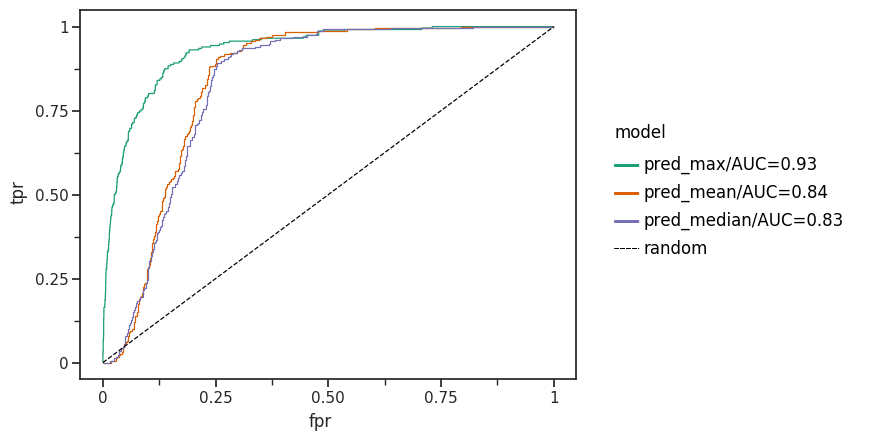

<ggplot: (-9223363293303646485)>


In [13]:
g = (
    p9.ggplot(
        performance_map["AUROC"]
        >> ply.call(
            ".append",
            pd.DataFrame(
                {
                    "fpr": [0, 0.25, 0.5, 0.75, 1],
                    "tpr": [0, 0.25, 0.5, 0.75, 1],
                    "model": "random",
                }
            ),
        )
    )
    + p9.aes(x="fpr", y="tpr", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
)
print(g)

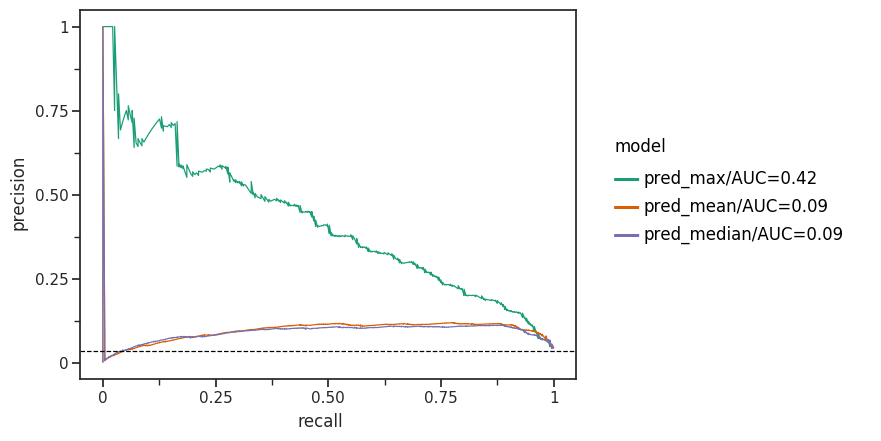

<ggplot: (8743576729159)>


In [14]:
g = (
    p9.ggplot(performance_map["PR"])
    + p9.aes(x="recall", y="precision", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
    + p9.geom_hline(
        yintercept=(
            test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet")
        ).mean(),
        linetype="dashed",
    )
)
print(g)

## Estimate number of new Edges Added

In [15]:
df_iterator = (
    performance_map["PR"]
    >> ply.query("model.str.contains('max')& pr_threshold < 1")
    >> ply.call(".round", {"pr_threshold": 2})
    >> ply.distinct("pr_threshold", "last")
)

edges_added_records = []
for idx, row in df_iterator.iterrows():
    cutoff = row["pr_threshold"]

    values_added = (
        all_ctd_df
        >> ply.query("metric.str.contains('max')")
        >> ply.query("score >= @cutoff")
        >> ply.pull("hetionet")
    )

    edges_added_records.append(
        {
            "edges": values_added.sum(),
            "in_hetionet": "Existing",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )

    edges_added_records.append(
        {
            "edges": values_added.shape[0] - values_added.sum(),
            "in_hetionet": "Novel",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )


edges_added_df = pd.DataFrame.from_records(edges_added_records)
edges_added_df >> ply.slice_rows(10)

,edges,in_hetionet,precision,sen_cutoff
0,1065,Existing,0.046568,0.14
1,23910,Novel,0.046568,0.14
2,1062,Existing,0.047728,0.15
3,23201,Novel,0.047728,0.15
4,1060,Existing,0.049152,0.16
5,22510,Novel,0.049152,0.16
6,1059,Existing,0.050585,0.17
7,21832,Novel,0.050585,0.17
8,1059,Existing,0.052235,0.18
9,21132,Novel,0.052235,0.18


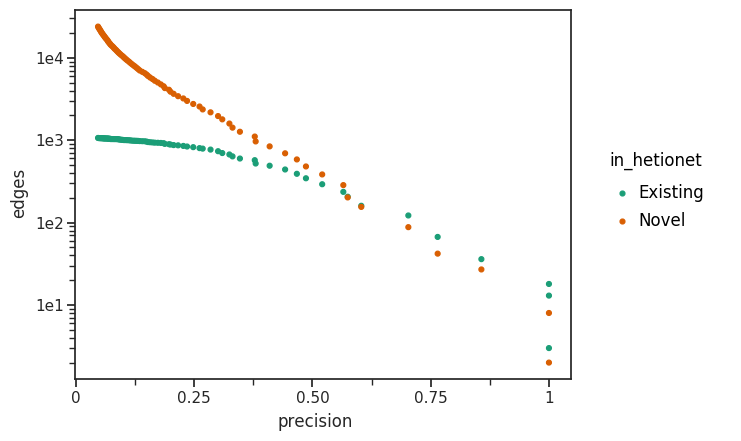

<ggplot: (-9223363293296447295)>


In [16]:
g = (
    p9.ggplot(edges_added_df >> ply.query("edges > 0 & precision > 0"))
    + p9.aes(x="precision", y="edges", color="in_hetionet")
    + p9.geom_point()
    + p9.theme_seaborn("white")
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.scale_y_log10()
)
print(g)

In [17]:
edges_df = pd.DataFrame.from_records(
    [
        {
            "recall": (
                all_ctd_df
                >> ply.query("metric=='pred_max' & score > 0.4")
                >> ply.pull("hetionet")
            ).sum()
            / all_ctd_df.query("hetionet == 1").shape[0],
            "edges": (
                all_ctd_df
                >> ply.query("metric=='pred_max' & score > 0.4")
                >> ply.pull("hetionet")
            ).sum(),
            "in_hetionet": "Existing",
            "relation": "CtD",
        },
        {
            "edges": (
                all_ctd_df
                >> ply.query("metric=='pred_max' & score > 0.4")
                >> ply.query("hetionet==0")
            ).shape[0],
            "in_hetionet": "Novel",
            "relation": "CtD",
        },
    ]
)

edges_df

,recall,edges,in_hetionet,relation
0,0.318011,1017,Existing,CtD
1,NaN,11146,Novel,CtD


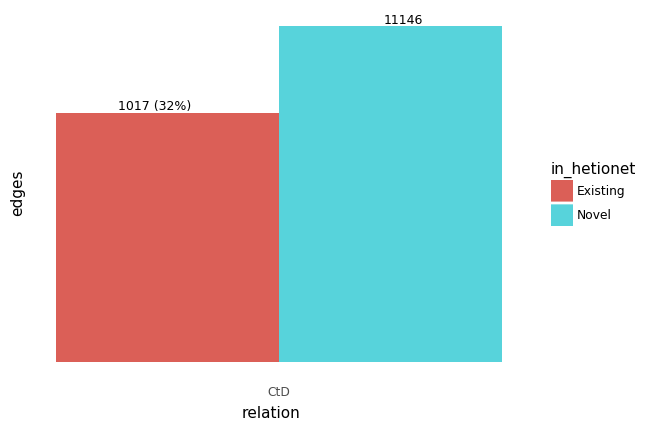

<ggplot: (8743579297288)>


In [18]:
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df.apply(
                    lambda x: f"{x['edges']} ({x['recall']*100:.0f}%)"
                    if not math.isnan(x["recall"])
                    else f"{x['edges']}",
                    axis=1,
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom",
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major=p9.element_blank(),
        rect=p9.element_blank(),
    )
)
print(g)